In [1]:
from my_commonfunctions import *

In [2]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape)
    for l in lines:
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(l)
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

29 3
(351, 217)




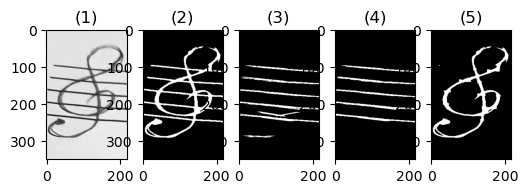

In [26]:
DEG_TO_RAD = np.pi/180

shubra1 = my_imread_gray('shubra1/13 6.jpg')
width = shubra1.shape[1]

# Otsu's thresholding after Gaussian filtering
ret, shubra1_thresh = cv2.threshold(shubra1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(shubra1_thresh)
print(distance_between_staves, staff_thickness)

shubra1_thresh = ~shubra1_thresh

line_length = int(width/4)
lines = probabilistic_hough_line(shubra1_thresh, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD))


lines_img_before_filteration = draw_hough_lines(lines, shubra1_thresh.shape, 1)
print(lines_img_before_filteration.shape)
lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 11)))
lines_img = np.copy(lines_img_before_filteration)
image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_bounding_rectangles = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    #print(x, y, w, h)
    contours_bounding_rectangles.append([c, [x, y, w, h]])

print()
print()

contours_bounding_rectangles_sorted = sorted(contours_bounding_rectangles, key = lambda x: x[1][2], reverse=True) # sort by width
contours_widest_5 = []
j = 5 if len(contours_bounding_rectangles_sorted) >= 5 else len(contours_bounding_rectangles_sorted)
for i in range(j):
    contours_widest_5.append(contours_bounding_rectangles_sorted[i][0])
    
lines_img = np.zeros(shubra1_thresh.shape, dtype=np.uint8)
lines_img = rgb2gray(cv2.drawContours(gray2rgb(lines_img), contours_widest_5, -1, (255,255,255), 1))
k = 3
lines_img = my_close(lines_img, np.ones((k*staff_thickness, k*staff_thickness)))
lines_img_flattened = (lines_img > 0.5).T.flatten()




shubra1_thresh_flattened = (shubra1_thresh).T.flatten()
#print(shubra1_thresh_flattened)
image, contours, hierarchy = cv2.findContours((shubra1_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)

for c in contours:
    if c.shape == (2, 1, 2):
        p1 = c[1][0][1]
        p0 = c[0][0][1]
        if p1 - p0 <= staff_thickness*1.55:
            #print(c)
            staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
            if staff_pixel_percentage > 0.35:
                shubra1_thresh_flattened[p0:p1+1] = 0
    elif c.shape == (1, 1, 2):
        #print(c)
        p0 = c[0][0][1]
        staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
        if staff_pixel_percentage > 0.35:
            shubra1_thresh_flattened[p0:p0+1] = 0


staff_lines_removed = shubra1_thresh_flattened.reshape(shubra1_thresh.T.shape).T

#print(shubra1_thresh)
cv2.imwrite('lines_img.png', (lines_img*255).astype(np.uint8))
cv2.imwrite('shubra1_thresh.png', (((shubra1_thresh) > 128)*255).astype(np.uint8))


my_show_images([shubra1, shubra1_thresh, lines_img_before_filteration, lines_img, staff_lines_removed], dpi=100, row_max=5)

In [4]:
?cv2.drawContours

Docstring:
drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset]]]]]) -> image
.   @brief Draws contours outlines or filled contours.
.   
.   The function draws contour outlines in the image if \f$\texttt{thickness} \ge 0\f$ or fills the area
.   bounded by the contours if \f$\texttt{thickness}<0\f$ . The example below shows how to retrieve
.   connected components from the binary image and label them: :
.   @include snippets/imgproc_drawContours.cpp
.   
.   @param image Destination image.
.   @param contours All the input contours. Each contour is stored as a point vector.
.   @param contourIdx Parameter indicating a contour to draw. If it is negative, all the contours are drawn.
.   @param color Color of the contours.
.   @param thickness Thickness of lines the contours are drawn with. If it is negative (for example,
.   thickness=#FILLED ), the contour interiors are drawn.
.   @param lineType Line connectivity. See #LineTypes
.   @